# Vehicle Recall Predictions

# Required Code

This is the code required to load the datasets we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import re

data_path = 'data'
fields_path = 'fields'

# Written by: David
# Read and parse a file containing column names for a dataset.
# Returns a list of strings (the column names).
def load_column_names(columns_file_name):
    file = open(columns_file_name)
    column_names = []
    readingFields = False
    for line in file:
        if readingFields:
            if re.match('^[0-9]', line):
                split_line = line.split()
                column_names.append(split_line[1])
        elif line.startswith('Field#'):
            readingFields = True
    file.close()
    return column_names
#}

# Written by: David
# Load a dataest by its abbreviated names (ex: RCL).
def load_data_file(name, encoding):
    
    # Read the column names from a separate file.
    fields_file_name = fields_path + '/' + name + '.txt';
    names = load_column_names(fields_file_name)
    
    # Read the data from a CSV file.
    data_file_name = 'FLAT_' + name + '.txt';
    df = pd.read_csv(data_path + '/' + data_file_name,
                     delimiter='\t', header=None, encoding=encoding, names=names)
    
    return df
#}

print("done")

done


# Data cleaning for prediction

## Load the Complaints dataset

In [2]:
# Load the complaints dataset.
# Only use a subset of the data (because there is a lot of it)
cmpl_train_df = load_data_file('CMPL', encoding='iso-8859-1')

C:\Users\whomp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (15,22,26,30,32,33,34,35,36,38,39,40,41,42,43,44,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## Filter and clean the Complaints dataset

In [3]:
# Written by: David
# Create list of the columns we will use.
# --Christian added DATEA as numerical column
key_cols = ['MAKETXT', 'MODELTXT', 'YEARTXT','COMPDESC']
cat_cols = ['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE']
bool_cols = ['CRASH', 'FIRE', 'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
numer_cols = bool_cols + ['INJURED', 'DEATHS', 'MILES', 'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED','DATEA']
all_cols = key_cols + numer_cols + cat_cols

# Written by: David
# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
clean_train_df = cmpl_train_df[(cmpl_train_df['MAKETXT'] != 'UNKNOWN') &
                   (cmpl_train_df['MODELTXT'] != 'UNKNOWN') &
                   (cmpl_train_df['YEARTXT'] > 1900) &
                   (cmpl_train_df['YEARTXT'] < 2020) &
                   (cmpl_train_df['PROD_TYPE'] == 'V')][all_cols + ['CMPLID']].copy()

# Written by: David
# Convert certain columns to a numerical data type.
clean_train_df['NUM_CYLS'] = pd.to_numeric(clean_train_df['NUM_CYLS'], errors='coerce')
clean_train_df['DATEA'] = pd.to_numeric(clean_train_df['DATEA'], errors='coerce')

# Written by: David
# Replace particular "bogus" values with NaN, which get filled later.
clean_train_df['INJURED'] = clean_train_df['INJURED'].replace(99, np.nan).fillna(0)
clean_train_df['DEATHS'] = clean_train_df['DEATHS'].replace(99, np.nan).fillna(0)

# Written by: David
# Clamp the values for specific numerical columns.
clean_train_df['NUM_CYLS'] = clean_train_df['NUM_CYLS'].clip(4, 8)
clean_train_df['MILES'] = clean_train_df['MILES'].clip(0, 300000)
clean_train_df['OCCURENCES'] = clean_train_df['OCCURENCES'].clip(1, 10)
clean_train_df['VEH_SPEED'] = clean_train_df['VEH_SPEED'].clip(0, 100)

# Written by: Christian
# Clean values in component descriptions
# Custom split function to pass to apply
def split(comp):
    if type(comp) != str:
        return ''
    return comp.split(':')[0]

# Written by: Christian
# Generalize the names of each component
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].apply(split)

# Written by: Christian
# Fix differences between component names in complaints and recalls
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('FUEL/PROPULSION SYSTEM','FUEL SYSTEM').replace('AIR BAG','AIR BAGS')
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('OTHER','').replace('UNKNOWN OR OTHER','')

# Written by: David
# Replace 'Y' and 'N' with 1 and 0 for boolean columns.
# Also convert them to numeric so we can average them.
# This will allow us to get a percentage of 'yes' for each vehicle type.
for column in bool_cols:
    clean_train_df[column] = clean_train_df[column].replace('Y', 1).replace('N', 0)
    clean_train_df[column] = pd.to_numeric(clean_train_df[column])

# Print out part of the resulting semi-clean data set
clean_train_df[all_cols].head(10)

,MAKETXT,MODELTXT,YEARTXT,COMPDESC,CRASH,FIRE,POLICE_RPT_YN,ORIG_OWNER_YN,ANTI_BRAKES_YN,CRUISE_CONT_YN,...,DEATHS,MILES,OCCURENCES,NUM_CYLS,VEH_SPEED,DATEA,DRIVE_TRAIN,FUEL_SYS,FUEL_TYPE,TRANS_TYPE
0,TOYOTA,LAND CRUISER,1994.0,"SERVICE BRAKES, HYDRAULIC",NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,19950103,NaN,NaN,NaN,NaN
1,TOYOTA,PASEO,1994.0,PARKING BRAKE,1.0,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,19950103,NaN,NaN,NaN,NaN
2,TOYOTA,COROLLA,1994.0,AIR BAGS,1.0,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,19950103,NaN,NaN,NaN,NaN
3,NISSAN,MAXIMA,1994.0,SUSPENSION,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,19950103,NaN,NaN,NaN,NaN
4,NISSAN,PATHFINDER,1994.0,SUSPENSION,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,19950103,NaN,NaN,NaN,NaN
6,FORD,PROBE,1991.0,SEAT BELTS,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,4.0,NaN,NaN,19950103,NaN,NaN,NaN,NaN
7,FORD,WINDSTAR,1995.0,"SERVICE BRAKES, HYDRAULIC",NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,19950103,NaN,NaN,NaN,NaN
8,CHEVROLET,CAPRICE,1991.0,VEHICLE SPEED CONTROL,1.0,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,19950103,NaN,NaN,NaN,NaN
9,HONDA,CIVIC,1994.0,AIR BAGS,1.0,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,1.0,NaN,NaN,19950103,NaN,NaN,NaN,NaN
10,CHEVROLET,LUMINA,1994.0,SEAT BELTS,NaN,0.0,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,19950103,NaN,NaN,NaN,NaN


## Group complaints by make/model/year and perform aggregate functions on the column values

Warning: this step takes a few minutes to perform all the aggregate functions

In [4]:
# Written by: David
# Aggregate function which Returns the mode of a series.
# If there is no valid mode, but there are any amount of
# non-null values, then the first non-null value is returned.
# Otherwise, if all values are NaN, then NaN is returned
def aggMode(x):
    column_mode = x.mode()
    
    # If there is a valid mode, return it
    if column_mode.count() > 0:
        return column_mode[0]
   
    # if there are any non-null values, return one of them
    first_valid = x.first_valid_index()
    if first_valid != None:
        return x[first_valid]
    
    return np.nan
#}

In [5]:
# Written by: David
# Group the dataset by the key columns (make/model/year/component)
grouped = clean_train_df.groupby(key_cols)

# Written by: David
# Perform aggregate functions on the columns for each vehicle type.
# Aggregate with the mode for categorical columns
# Aggregate with the mean for numerical columns
grouped_df = pd.DataFrame()
for col in cat_cols:
    grouped_df[col] = grouped[col].agg(aggMode)
for col in numer_cols:
    grouped_df[col] = grouped[col].mean()

# Written by: David
# Add in a column for the number of complaints for each vehicle-component.
grouped_df['COMPLAINTS'] = grouped.size()
numer_cols.append('COMPLAINTS');
all_cols.append('COMPLAINTS');

print('done')

done


## Replace missing values with the mean or mode for that column over the entire dataset

In [6]:
# Written by: David

# Replace NaN with mode for categorical columns
for col in cat_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mode()[0])

# Replace NaN with mean for numerical columns
for col in numer_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mean())

print('done')

done


In [7]:
# Print out the grouped dataset.
grouped_df

DRIVE_TRAIN  \
MAKETXT         MODELTXT          YEARTXT COMPDESC                                   
.               MALIBU            1998.0  EXTERIOR LIGHTING                    FWD   
3 TON UTILITY   3EC14             2003.0  STRUCTURE                            FWD   
                                          TRAILER HITCHES                      FWD   
4 TON UTILITY   4EC16W            2001.0  ELECTRONIC STABILITY CONTROL         FWD   
                                          STEERING                             FWD   
                                          VEHICLE SPEED CONTROL                FWD   
                                  2002.0  ELECTRONIC STABILITY CONTROL         FWD   
                                          STRUCTURE                            FWD   
4-STAR          HORSE TRAILER     2006.0  ELECTRICAL SYSTEM                    FWD   
                                          ENGINE                               FWD   
                                          EXTERIOR LIGHTING                    FWD   
                                  2008.0  POWER TRAIN                          FWD   
                                  2012.0  ELECTRONIC STABILITY CONTROL         FWD   
                                          ENGINE                               FWD   
                                          FUEL SYSTEM, GASOLINE                FWD   
4-STAR TRAILER  CARGO BUMPER PULL 2000.0  POWER TRAIN                          FWD   
                                          SERVICE BRAKES                       FWD   
                                  2005.0  SERVICE BRAKES                       FWD   
                CARGO GOOSENECK   2005.0  STEERING                             FWD   
                                          SUSPENSION                           FWD   
                HORSE BUMPER PULL 2008.0                                       FWD   
                HORSE GOOSENECK   2001.0  WHEELS                               FWD   
                                  2009.0  SERVICE BRAKES                       FWD   
                POLO GOOSENECK    2006.0  ELECTRICAL SYSTEM                    FWD   
                                  2007.0  ELECTRICAL SYSTEM                    FWD   
                STOCK BUMPER PULL 2003.0  SERVICE BRAKES                       FWD   
                                  2010.0  AIR BAGS                             FWD   
4-STAR TRAILERS HORSE TRAILER     2003.0  STRUCTURE                            FWD   
                                  2004.0  SUSPENSION                           FWD   
                                          TIRES                                FWD   
...                                                                            ...   
YAMAHA          ZUMA              2009.0  ELECTRICAL SYSTEM                    FWD   
                                          FUEL SYSTEM                          FWD   
                                          FUEL SYSTEM, GASOLINE                FWD   
                                  2011.0  ELECTRICAL SYSTEM                    FWD   
                                          ENGINE                               FWD   
                                          FUEL SYSTEM                          FWD   
YAMAHA V STAR   1100 SILVERADO    2006.0  ELECTRICAL SYSTEM                    RWD   
                                          POWER TRAIN                          RWD   
YOKOHAMA        YOKOHAMA          1990.0  TIRES                                FWD   
                                  1994.0  TIRES                                FWD   
ZAP             XEBRA             2008.0                                       FWD   
                                          ELECTRICAL SYSTEM                    FWD   
                                          FUEL SYSTEM, GASOLINE                FWD   
                                          POWER TRAIN                          FWD   
                             

## Check which vehicle types exist in the Recalls dataset

Warning: This is the longest step and it will take several minutes

In [8]:
# Load the recall dataset
rcl_df = load_data_file('RCL', encoding='latin1');

C:\Users\whomp\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2821: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [9]:
# Written by: Christian
# Rename the component field in recalls so it matches complaints
recalled_set = rcl_df.rename(columns = {'COMPNAME':'COMPDESC'})

# Written by: David
# Create the set of vehicle types from the recalled dataset.
# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
#--Christian - switched to all columns, doesn't take much longer and makes next part easier
recalled_set = recalled_set[(rcl_df['MAKETXT'] != 'UNKNOWN') &
                      (rcl_df['MODELTXT'] != 'UNKNOWN') &
                      (rcl_df['YEARTXT'] > 1900) &
                      (rcl_df['YEARTXT'] < 2020) &
                      (rcl_df['RCLTYPECD'] == 'V')][recalled_set.columns.values].copy()

# Written by: Christian
# Generalize the names of each component
recalled_set['COMPDESC'] = recalled_set['COMPDESC'].apply(split)

# Convert Date to a numeric value
recalled_set['RCDATE'] = pd.to_numeric(recalled_set['RCDATE'], errors='coerce')


# Written by: David
# Make the recalled set only have unique vehicle types,
# mostly for efficiency in the next step.
recalled_set = recalled_set[key_cols + ["RCDATE"]].groupby(key_cols)
print("done")

done


In [10]:
# Written by: Matt/Christian
# Now create the columns in the complaints set which says
# whether a vehicle type is in the recalled sets.
# --Christian - switched so it only counts as recalled if the recall happened after the complaint
# added whether or not the car was recalled within a period of time
# switched to a mix of integer and label indexing for accuracy purposes
grouped_df['RECALLED'] = False
grouped_df['RECALLED_1YR'] = False
grouped_df['RECALLED_3YR'] = False
grouped_df['RECALLED_5YR'] = False
for int_index in range(len(grouped_df)):
    #get the old label based index aka key_cols
    index = grouped_df.iloc[int_index].name
    #key exists in recalls
    if(index in recalled_set.indices):
        #list of all recall dates YYYYMMDD format
        recalled_dates = recalled_set.get_group(index)["RCDATE"].get_values()
        #date of current recall
        comp_date = grouped_df.iloc[int_index]["DATEA"]
        for rcl_date in recalled_dates:
            if comp_date < rcl_date:
                grouped_df.ix[int_index,'RECALLED'] = True
                if comp_date + 50000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_5YR"] = True
                if comp_date + 30000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_3YR"] = True
                if comp_date + 10000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_1YR"] = True
print(grouped_df['RECALLED'].value_counts())
print(grouped_df['RECALLED_5YR'].value_counts())
print(grouped_df['RECALLED_3YR'].value_counts())
print(grouped_df['RECALLED_1YR'].value_counts())


False    155189
True       3996
Name: RECALLED, dtype: int64
False    155499
True       3686
Name: RECALLED_5YR, dtype: int64
False    155919
True       3266
Name: RECALLED_3YR, dtype: int64
False    157202
True       1983
Name: RECALLED_1YR, dtype: int64


In [11]:
grouped_df.loc[grouped_df['RECALLED'] == True]

DRIVE_TRAIN  \
MAKETXT   MODELTXT            YEARTXT COMPDESC                                
ACURA     CL                  2003.0  AIR BAGS                          FWD   
          ILX                 2014.0  AIR BAGS                          FWD   
          LEGEND              1992.0  EQUIPMENT                         FWD   
          MDX                 2003.0  AIR BAGS                          AWD   
                                      ELECTRICAL SYSTEM                 FWD   
                              2004.0  AIR BAGS                          AWD   
                              2005.0  AIR BAGS                          AWD   
                                      ELECTRICAL SYSTEM                   U   
                                      SERVICE BRAKES, HYDRAULIC         FWD   
                              2006.0  AIR BAGS                          FWD   
                                      ELECTRICAL SYSTEM                 FWD   
                                      SERVICE BRAKES, HYDRAULIC         FWD   
                              2016.0  FUEL SYSTEM, GASOLINE             FWD   
          RDX                 2007.0  AIR BAGS                          AWD   
                              2008.0  AIR BAGS                          AWD   
          RL                  2005.0  AIR BAGS                          AWD   
                                      SERVICE BRAKES, HYDRAULIC         AWD   
                                      STEERING                          AWD   
                              2006.0  AIR BAGS                          AWD   
                                      SERVICE BRAKES, HYDRAULIC         AWD   
                              2007.0  AIR BAGS                          FWD   
                                      SERVICE BRAKES, HYDRAULIC         AWD   
                              2009.0  AIR BAGS                          FWD   
          RLX                 2014.0  EXTERIOR LIGHTING                 FWD   
          RSX                 2006.0  SERVICE BRAKES, HYDRAULIC         FWD   
          TL                  2002.0  AIR BAGS                          FWD   
                              2003.0  AIR BAGS                          FWD   
                              2012.0  AIR BAGS                          FWD   
          TSX                 2004.0  ELECTRICAL SYSTEM                 FWD   
                                      ENGINE AND ENGINE COOLING         FWD   
...                                                                     ...   
WINNEBAGO MINNIE              2004.0  EQUIPMENT                         FWD   
          MINNIE WINNIE       2003.0  EQUIPMENT                         FWD   
          SIGHTSEER           2002.0  EQUIPMENT                         FWD   
                              2003.0  EQUIPMENT                         RWD   
                                      SERVICE BRAKES, HYDRAULIC         RWD   
                              2004.0  EQUIPMENT                         FWD   
                                      SERVICE BRAKES, HYDRAULIC         FWD   
                              2005.0  EQUIPMENT                         RWD   
                                      SEAT BELTS                        FWD   
                              2007.0  ELECTRICAL SYSTEM                   U   
          TRAVATO             2016.0  ELECTRICAL SYSTEM                 FWD   
          VIA                 2012.0  ELECTRICAL SYSTEM                 FWD   
          VISTA               2015.0  POWER TRAIN                       FWD   
WORKHORSE W20                 2001.0  SERVICE BRAKES, HYDRAULIC         RWD   
                              2002.0  SERVICE BRAKES, HYDRAULIC         RWD   
                              2003.0  SERVICE BRAKES, HYDRAULIC         RWD   
                              2004.0  SERVICE BRAKES, HYDRAULIC         RWD   
          W22                 2001.0  SERVICE BRAKES, HYDRAULIC         RWD   
YAMAHA    FJR1300             2007.

# Random Decision Forest Prediction

## Import required libraries

In [12]:
# Written by: Matt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## Prepare data for training and validation

In [13]:
# Function to grab 'n' number of random samples from a dataframe 'x'
import random
def some(x, n):
    return x.ix[random.sample(set(x.index), n)]

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData = some(recalledSamples, numSamples)
fullData = fullData.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_5YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_5YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_5yr = some(recalledSamples, numSamples)
fullData_5yr = fullData_5yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_3YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_3YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_3yr = some(recalledSamples, numSamples)
fullData_3yr = fullData_3yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_1YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_1YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_1yr = some(recalledSamples, numSamples)
fullData_1yr = fullData_1yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

Gathered 3996 recalled components and 3996 non-recalled components
Gathered 3686 recalled components and 3686 non-recalled components
Gathered 3266 recalled components and 3266 non-recalled components
Gathered 1983 recalled components and 1983 non-recalled components


In [14]:
# Written by: David
# Drop columns that have missing values. Our previous
# steps would have filled all missing values UNLESS
# the column is entirely filled with null. Therefore,
# just drop columns that are null, they don't tell us anything.
for col in cat_cols + numer_cols:
    if fullData[col].isnull().any():
        print('Dropping column ', col)
        fullData.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_5yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_5yr.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_3yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_3yr.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_1yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_1yr.drop(col, axis=1,inplace=True)

# Written by: Matt
# Create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    fullData[var] = number.fit_transform(fullData[var].astype('str'))
    fullData_5yr[var] = number.fit_transform(fullData_5yr[var].astype('str'))
    fullData_3yr[var] = number.fit_transform(fullData_3yr[var].astype('str'))
    fullData_1yr[var] = number.fit_transform(fullData_1yr[var].astype('str'))

# Written by: Matt
# Target variable is also a categorical so convert it
fullData['RECALLED'] = number.fit_transform(fullData['RECALLED'].astype('str'))
fullData_5yr['RECALLED_5YR'] = number.fit_transform(fullData_5yr['RECALLED_5YR'].astype('str'))
fullData_3yr['RECALLED_3YR'] = number.fit_transform(fullData_3yr['RECALLED_3YR'].astype('str'))
fullData_1yr['RECALLED_1YR'] = number.fit_transform(fullData_1yr['RECALLED_1YR'].astype('str'))

# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData['is_train'] = np.random.uniform(0, 1, len(fullData)) <= .75
Train, Validate = fullData[fullData['is_train']==True], fullData[fullData['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])
print()

Training set size = 6027
Validation set size = 1965



# Run Testing for Recalled target

In [15]:
# Written by: Matt
# Get a list of the defining features.
features = list(set(list(fullData.columns)) - set(['RECALLED','RECALLED_5YR','RECALLED_1YR','RECALLED_3YR']))

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED'].values

## Calculate and plot the ROC Curve

In [16]:
# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

Area under ROC curve = 0.757230833318


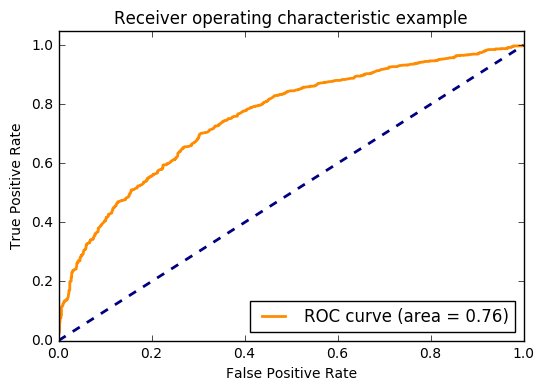

In [17]:
# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Calculate the Confusion Matrix

In [18]:
# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')


confusion matrix:
[[708 291]
 [319 647]]

708  non-recalled cars were predicted to be not recalled
291  non-recalled cars were predicted to be recalled
319  recalled cars were predicted to be not recalled
647  recalled cars were predicted to be recalled


## Calculate the Accuracy & Mean Squared Error

In [19]:
# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

accuracy = 0.689567430025
Mean squared error = 0.310432569975


# Run Testing for Recalled within five year target

Training set size = 5540
Validation set size = 1832
Area under ROC curve = 0.760341093698


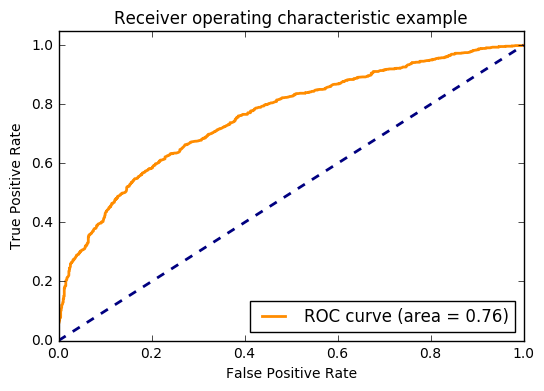

confusion matrix:
[[605 304]
 [271 652]]

605  non-recalled cars were predicted to be not recalled
304  non-recalled cars were predicted to be recalled
271  recalled cars were predicted to be not recalled
652  recalled cars were predicted to be recalled
accuracy = 0.686135371179
Mean squared error = 0.313864628821


In [20]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_5yr['is_train'] = np.random.uniform(0, 1, len(fullData_5yr)) <= .75
Train, Validate = fullData_5yr[fullData_5yr['is_train']==True], fullData_5yr[fullData_5yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED_5YR'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_5YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

# Run Testing for Recalled within three year target

Training set size = 4874
Validation set size = 1658
Area under ROC curve = 0.931620952059


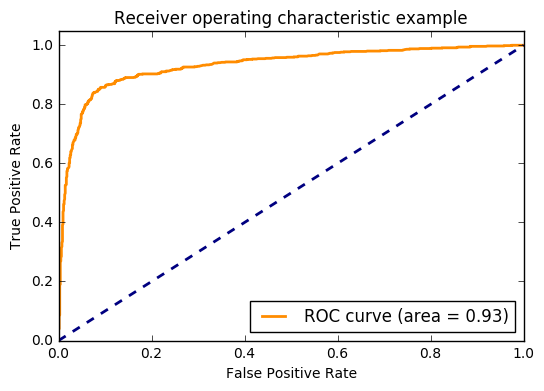

confusion matrix:
[[602 242]
 [ 60 754]]

602  non-recalled cars were predicted to be not recalled
242  non-recalled cars were predicted to be recalled
60  recalled cars were predicted to be not recalled
754  recalled cars were predicted to be recalled
accuracy = 0.817852834741
Mean squared error = 0.182147165259


In [21]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_3yr['is_train'] = np.random.uniform(0, 1, len(fullData_3yr)) <= .75
Train, Validate = fullData_3yr[fullData_3yr['is_train']==True], fullData_3yr[fullData_3yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_3YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

# Run Testing for 1 year target

Training set size = 3021
Validation set size = 945
Area under ROC curve = 0.790445988346


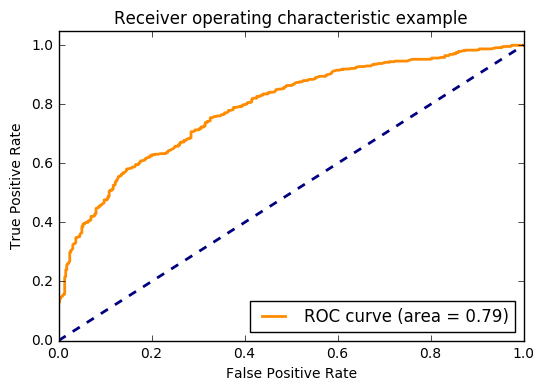

confusion matrix:
[[343 117]
 [166 319]]

343  non-recalled cars were predicted to be not recalled
117  non-recalled cars were predicted to be recalled
166  recalled cars were predicted to be not recalled
319  recalled cars were predicted to be recalled
accuracy = 0.700529100529
Mean squared error = 0.299470899471


In [22]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_1yr['is_train'] = np.random.uniform(0, 1, len(fullData_1yr)) <= .75
Train, Validate = fullData_1yr[fullData_1yr['is_train']==True], fullData_1yr[fullData_1yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED_1YR'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_1YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

In [23]:
grouped_df.to_csv("fullData.txt")